In [26]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from tqdm import tqdm
import torchvision.models as models
import PIL
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder'

In [28]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
val_data = datasets.ImageFolder(os.path.join(data_path, 'valid'), transform = test_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform = test_transform)
val_loader = DataLoader(val_data, batch_size= 32, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 32, shuffle= False,)

In [29]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_augmentations=3):
        self.dataset = original_dataset
        self.num_augmentations = num_augmentations
        self.classes = original_dataset.classes
        self.class_to_idx = original_dataset.class_to_idx
        self.samples = original_dataset.samples
        
    def __getitem__(self, idx):
        original_idx = idx // (self.num_augmentations + 1)
        is_augmented = idx % (self.num_augmentations + 1)
        
        if is_augmented == 0:
            return self.dataset[original_idx]
        
        # Load and transform image directly
        image_path = self.samples[original_idx][0]
        label = self.samples[original_idx][1]
        image = Image.open(image_path).convert('RGB')
        image = self.dataset.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.dataset) * (self.num_augmentations + 1)
augmented_train_data = AugmentedDataset(train_data, num_augmentations=3)
train_loader = DataLoader(augmented_train_data, batch_size=32, shuffle=True)

In [30]:
classes = ['Angry','Sad','happy','Other']
class_names = augmented_train_data.classes
print(class_names)
print(f'Number of train images: {len(augmented_train_data)}')
print(f'Number of validation images: {len(val_data)}')
print(f'Number of test images: {len(test_data)}')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 4000
Number of validation images: 36
Number of test images: 38
Available processor cuda


In [31]:
def plot_confusion_matrix(cm):
    class_names = ['Angry','Sad','happy','Other']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [32]:
class myVGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(myVGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = myVGG16(num_classes=4).to(device)
print(model)

myVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Epoch 1/10
Train Loss: 1.3864, Train Accuracy: 25.32%
Validation Loss: 1.3864, Validation Accuracy: 27.78%
Epoch 2/10
Train Loss: 1.3865, Train Accuracy: 24.07%
Validation Loss: 1.3857, Validation Accuracy: 27.78%
Epoch 3/10
Train Loss: 1.3865, Train Accuracy: 24.23%
Validation Loss: 1.3861, Validation Accuracy: 27.78%
Epoch 4/10
Train Loss: 1.3836, Train Accuracy: 27.00%
Validation Loss: 1.3820, Validation Accuracy: 19.44%
Epoch 5/10
Train Loss: 1.3477, Train Accuracy: 34.00%
Validation Loss: 1.4284, Validation Accuracy: 33.33%
Epoch 6/10
Train Loss: 1.3069, Train Accuracy: 38.77%
Validation Loss: 1.2892, Validation Accuracy: 38.89%
Epoch 7/10
Train Loss: 1.2420, Train Accuracy: 43.40%
Validation Loss: 1.3427, Validation Accuracy: 33.33%
Epoch 8/10
Train Loss: 1.1853, Train Accuracy: 46.58%
Validation Loss: 1.7707, Validation Accuracy: 38.89%
Epoch 9/10
Train Loss: 1.1041, Train Accuracy: 52.23%
Validation Loss: 1.4112, Validation Accuracy: 25.00%
Epoch 10/10
Train Loss: 0.9847, Train

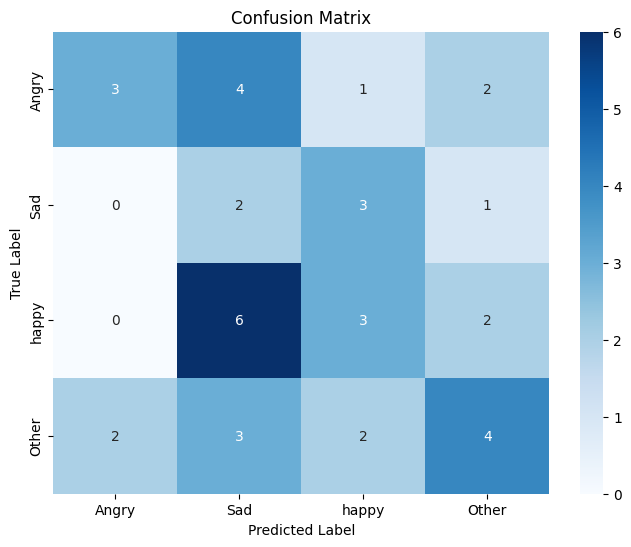

In [33]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing Loop with Metrics
model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)


In [34]:
class BottleneckBlock(nn.Module):
    expansion = 4  # For ResNet50, the output channels are expanded by 4x

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.construct_layer(block, 64, layers[0])
        self.layer2 = self.construct_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.construct_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.construct_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def construct_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = ResNet50(BottleneckBlock, [3, 4, 6, 3], num_classes=4).to(device)

print(model)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [35]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)

        out = out + identity
        out = self.relu(out)

        return out

class myResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(myResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.construct_layer(block, 64, layers[0])
        self.layer2 = self.construct_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.construct_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.construct_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def construct_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = myResNet34(BasicBlock, [3, 4, 6, 3], 4).to(device)

Epoch 1/10
Train Loss: 1.3627, Train Accuracy: 32.25%
Validation Loss: 1.3621, Validation Accuracy: 30.56%
Epoch 2/10
Train Loss: 1.2649, Train Accuracy: 43.30%
Validation Loss: 1.6980, Validation Accuracy: 33.33%
Epoch 3/10
Train Loss: 1.1637, Train Accuracy: 49.30%
Validation Loss: 1.7891, Validation Accuracy: 38.89%
Epoch 4/10
Train Loss: 1.0637, Train Accuracy: 55.02%
Validation Loss: 1.5479, Validation Accuracy: 38.89%
Epoch 5/10
Train Loss: 0.9497, Train Accuracy: 60.38%
Validation Loss: 2.4467, Validation Accuracy: 33.33%
Epoch 6/10
Train Loss: 0.8551, Train Accuracy: 65.00%
Validation Loss: 1.9952, Validation Accuracy: 30.56%
Epoch 7/10
Train Loss: 0.7508, Train Accuracy: 69.35%
Validation Loss: 1.7688, Validation Accuracy: 41.67%
Epoch 8/10
Train Loss: 0.6379, Train Accuracy: 75.20%
Validation Loss: 1.5653, Validation Accuracy: 47.22%
Epoch 9/10
Train Loss: 0.5501, Train Accuracy: 78.70%
Validation Loss: 2.5550, Validation Accuracy: 50.00%
Epoch 10/10
Train Loss: 0.4886, Train

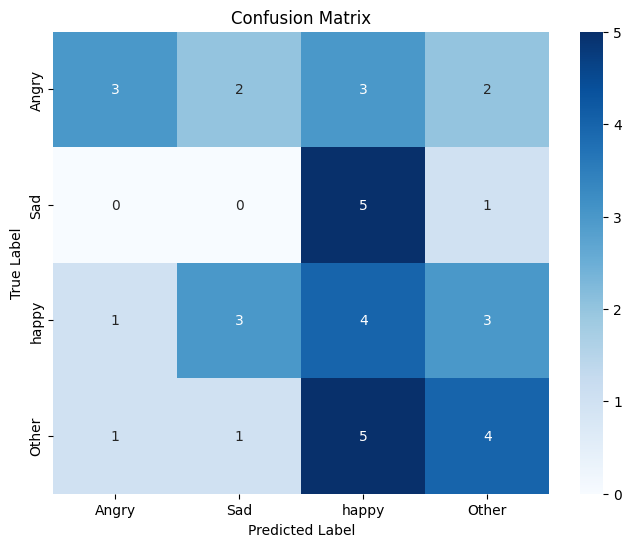

In [36]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing Loop with Metrics
model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)

In [37]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()
        
        # Define the initial Conv2D layer
        self.features = nn.Sequential(
            ConvBNReLU(3, 32, stride=2),  # Input size: 224x224x3 -> Output size: 112x112x32
            Bottleneck(32, 16, expansion_factor=1, stride=1, repeat=1),  # 112x112x32 -> 112x112x16
            Bottleneck(16, 24, expansion_factor=6, stride=2, repeat=2),  # 112x112x16 -> 56x56x24
            Bottleneck(24, 32, expansion_factor=6, stride=2, repeat=3),  # 56x56x24 -> 28x28x32
            Bottleneck(32, 64, expansion_factor=6, stride=2, repeat=4),  # 28x28x32 -> 14x14x64
            Bottleneck(64, 96, expansion_factor=6, stride=1, repeat=3),  # 14x14x64 -> 14x14x96
            Bottleneck(96, 160, expansion_factor=6, stride=2, repeat=3), # 14x14x96 -> 7x7x160
            Bottleneck(160, 320, expansion_factor=6, stride=1, repeat=1),# 7x7x160 -> 7x7x320
            ConvBNReLU(320, 1280, stride=1)  # 7x7x320 -> 7x7x1280
        )
        
        # Define the classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Average Pooling: 7x7x1280 -> 1x1x1280
        self.classifier = nn.Linear(1280, num_classes)  # Fully connected: 1x1x1280 -> num_classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class ConvBNReLU(nn.Module):
    """Convolution followed by BatchNorm and ReLU6"""
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Bottleneck(nn.Module):
    """Bottleneck block with depthwise separable convolution"""
    def __init__(self, in_channels, out_channels, expansion_factor, stride, repeat):
        super(Bottleneck, self).__init__()
        layers = []
        for i in range(repeat):
            stride_ = stride if i == 0 else 1
            layers.append(BottleneckBlock(in_channels, out_channels, expansion_factor, stride_))
            in_channels = out_channels  # Update in_channels for subsequent blocks
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class BottleneckBlock(nn.Module):
    """Single Bottleneck Block"""
    def __init__(self, in_channels, out_channels, expansion_factor, stride):
        super(BottleneckBlock, self).__init__()
        hidden_dim = in_channels * expansion_factor
        self.use_residual = stride == 1 and in_channels == out_channels

        self.layers = nn.Sequential(
            # Pointwise (1x1) Conv for expansion
            ConvBNReLU(in_channels, hidden_dim, stride=1),
            # Depthwise (3x3) Conv
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Pointwise (1x1) Conv for projection
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.layers(x)
        else:
            return self.layers(x)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # Replace with the number of classes in your task
model = MobileNet(num_classes=num_classes).to(device)

print(model)


MobileNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
    )
    (1): Bottleneck(
      (block): Sequential(
        (0): BottleneckBlock(
          (layers): Sequential(
            (0): ConvBNReLU(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): ReLU6(inplace=True)
            (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

Epoch 1/10
Train Loss: 1.3736, Train Accuracy: 28.90%
Validation Loss: 1.2262, Validation Accuracy: 38.89%
Epoch 2/10
Train Loss: 1.3624, Train Accuracy: 31.38%
Validation Loss: 1.3543, Validation Accuracy: 36.11%
Epoch 3/10
Train Loss: 1.3532, Train Accuracy: 33.23%
Validation Loss: 1.2072, Validation Accuracy: 38.89%
Epoch 4/10
Train Loss: 1.3423, Train Accuracy: 33.58%
Validation Loss: 1.3055, Validation Accuracy: 38.89%
Epoch 5/10
Train Loss: 1.3385, Train Accuracy: 34.67%
Validation Loss: 1.3824, Validation Accuracy: 30.56%
Epoch 6/10
Train Loss: 1.3340, Train Accuracy: 35.48%
Validation Loss: 1.2615, Validation Accuracy: 44.44%
Epoch 7/10
Train Loss: 1.3225, Train Accuracy: 37.17%
Validation Loss: 1.3224, Validation Accuracy: 33.33%
Epoch 8/10
Train Loss: 1.3098, Train Accuracy: 38.25%
Validation Loss: 1.2684, Validation Accuracy: 33.33%
Epoch 9/10
Train Loss: 1.2999, Train Accuracy: 38.75%
Validation Loss: 1.4202, Validation Accuracy: 36.11%
Epoch 10/10
Train Loss: 1.2926, Train

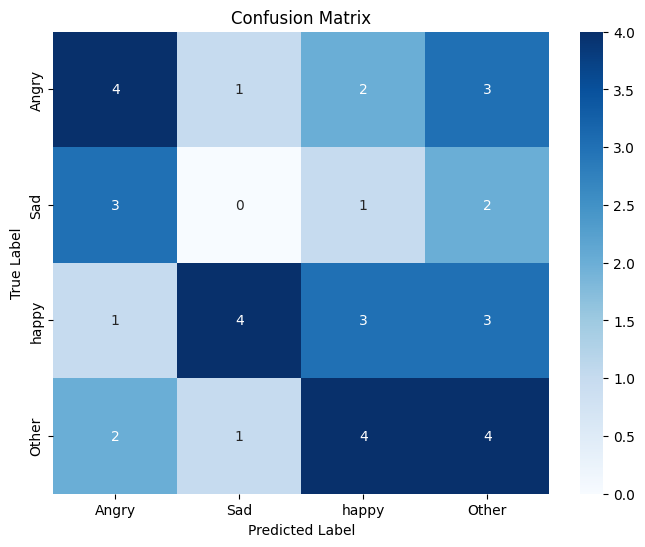

In [38]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing Loop with Metrics
model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)

In [39]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionBlock, self).__init__()
        
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )
        
        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class InceptionV3(nn.Module):
    def __init__(self, num_classes=4):
        super(InceptionV3, self).__init__()
        
        # Initial layers
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # Inception blocks
        self.inception1 = InceptionBlock(64, 64, 48, 64, 64, 96, 32)
        self.inception2 = InceptionBlock(256, 64, 48, 64, 64, 96, 64)
        self.inception3 = InceptionBlock(288, 92, 48, 64, 64, 96, 64)
        
        # Reduction block
        self.reduction1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(316, 384, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )
        
        # Additional inception blocks
        self.inception4 = InceptionBlock(384, 192, 96, 208, 16, 48, 64)
        self.inception5 = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        
        # Classification layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.reduction1(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = InceptionV3(num_classes=4).to(device)
print(model)

InceptionV3(
  (pre_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionBlock(
    (branch1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): Conv2d(64, 48, kernel_size=(1, 1), stride=(

Epoch 1/10
Train Loss: 1.3634, Train Accuracy: 31.45%
Validation Loss: 1.3226, Validation Accuracy: 30.56%
Epoch 2/10
Train Loss: 1.2946, Train Accuracy: 39.67%
Validation Loss: 1.2821, Validation Accuracy: 36.11%
Epoch 3/10
Train Loss: 1.2282, Train Accuracy: 45.38%
Validation Loss: 1.4027, Validation Accuracy: 38.89%
Epoch 4/10
Train Loss: 1.1660, Train Accuracy: 49.83%
Validation Loss: 1.4000, Validation Accuracy: 36.11%
Epoch 5/10
Train Loss: 1.1138, Train Accuracy: 52.65%
Validation Loss: 1.4898, Validation Accuracy: 36.11%
Epoch 6/10
Train Loss: 1.0564, Train Accuracy: 56.38%
Validation Loss: 1.1994, Validation Accuracy: 41.67%
Epoch 7/10
Train Loss: 1.0035, Train Accuracy: 58.42%
Validation Loss: 1.2974, Validation Accuracy: 30.56%
Epoch 8/10
Train Loss: 0.9377, Train Accuracy: 61.55%
Validation Loss: 1.2796, Validation Accuracy: 36.11%
Epoch 9/10
Train Loss: 0.8822, Train Accuracy: 65.10%
Validation Loss: 1.4317, Validation Accuracy: 41.67%
Epoch 10/10
Train Loss: 0.8494, Train

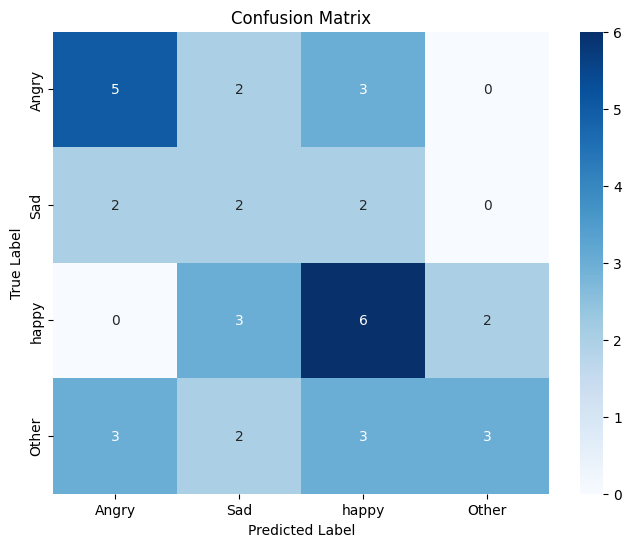

In [40]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing Loop with Metrics
model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)

In [41]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1),
            nn.BatchNorm2d(4 * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        return torch.cat([x, self.layers(x)], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate)
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.layers(x)

class DenseNet121(nn.Module):
    def __init__(self, num_classes=4, growth_rate=32):
        super(DenseNet121, self).__init__()
        
        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Dense blocks and transition layers
        num_features = 64
        block_config = [6, 12, 24, 16]  # Number of layers in each dense block
        
        # Dense Block 1
        self.denseblock1 = DenseBlock(num_features, block_config[0], growth_rate)
        num_features = num_features + block_config[0] * growth_rate
        self.transition1 = TransitionLayer(num_features, num_features // 2)
        num_features = num_features // 2
        
        # Dense Block 2
        self.denseblock2 = DenseBlock(num_features, block_config[1], growth_rate)
        num_features = num_features + block_config[1] * growth_rate
        self.transition2 = TransitionLayer(num_features, num_features // 2)
        num_features = num_features // 2
        
        # Dense Block 3
        self.denseblock3 = DenseBlock(num_features, block_config[2], growth_rate)
        num_features = num_features + block_config[2] * growth_rate
        self.transition3 = TransitionLayer(num_features, num_features // 2)
        num_features = num_features // 2
        
        # Dense Block 4
        self.denseblock4 = DenseBlock(num_features, block_config[3], growth_rate)
        num_features = num_features + block_config[3] * growth_rate
        
        # Final layers
        self.final = nn.Sequential(
            nn.BatchNorm2d(num_features),
            nn.ReLU(inplace=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        
        x = self.denseblock1(x)
        x = self.transition1(x)
        
        x = self.denseblock2(x)
        x = self.transition2(x)
        
        x = self.denseblock3(x)
        x = self.transition3(x)
        
        x = self.denseblock4(x)
        x = self.final(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

model = DenseNet121(num_classes=4).to(device)
print(model)

DenseNet121(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (denseblock1): DenseBlock(
    (layers): ModuleList(
      (0): DenseLayer(
        (layers): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): DenseLayer(
        (layers): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Epoch 1/10
Train Loss: 1.3423, Train Accuracy: 35.30%
Validation Loss: 1.3451, Validation Accuracy: 30.56%
Epoch 2/10
Train Loss: 1.2488, Train Accuracy: 45.30%
Validation Loss: 1.3174, Validation Accuracy: 36.11%
Epoch 3/10
Train Loss: 1.1600, Train Accuracy: 50.55%
Validation Loss: 1.5790, Validation Accuracy: 41.67%
Epoch 4/10
Train Loss: 1.0521, Train Accuracy: 56.70%
Validation Loss: 1.7142, Validation Accuracy: 36.11%
Epoch 5/10
Train Loss: 0.9547, Train Accuracy: 60.80%
Validation Loss: 1.4959, Validation Accuracy: 38.89%
Epoch 6/10
Train Loss: 0.8650, Train Accuracy: 66.30%
Validation Loss: 1.7969, Validation Accuracy: 44.44%
Epoch 7/10
Train Loss: 0.7638, Train Accuracy: 71.95%
Validation Loss: 1.2061, Validation Accuracy: 38.89%
Epoch 8/10
Train Loss: 0.6867, Train Accuracy: 75.58%
Validation Loss: 1.2104, Validation Accuracy: 38.89%
Epoch 9/10
Train Loss: 0.5988, Train Accuracy: 78.90%
Validation Loss: 1.2678, Validation Accuracy: 33.33%
Epoch 10/10
Train Loss: 0.5168, Train

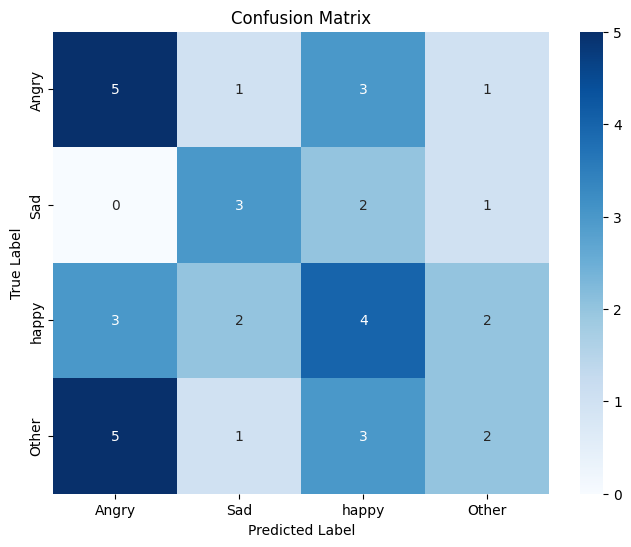

In [42]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing Loop with Metrics
model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)

In [53]:
import torchvision.models as models

model = models.inception_v3(pretrained=True)

# Modify final layer
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move entire model to device
model = model.to(device)

In [54]:
train_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # Changed from 224 to 299
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),  # Changed from 224 to 299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
val_data = datasets.ImageFolder(os.path.join(data_path, 'valid'), transform = test_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform = test_transform)
val_loader = DataLoader(val_data, batch_size= 32, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 32, shuffle= False,)
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_augmentations=3):
        self.dataset = original_dataset
        self.num_augmentations = num_augmentations
        self.classes = original_dataset.classes
        self.class_to_idx = original_dataset.class_to_idx
        self.samples = original_dataset.samples
        
    def __getitem__(self, idx):
        original_idx = idx // (self.num_augmentations + 1)
        is_augmented = idx % (self.num_augmentations + 1)
        
        if is_augmented == 0:
            return self.dataset[original_idx]
        
        # Load and transform image directly
        image_path = self.samples[original_idx][0]
        label = self.samples[original_idx][1]
        image = Image.open(image_path).convert('RGB')
        image = self.dataset.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.dataset) * (self.num_augmentations + 1)
augmented_train_data = AugmentedDataset(train_data, num_augmentations=3)
train_loader = DataLoader(augmented_train_data, batch_size=32, shuffle=True)

Epoch 1/10
Train Loss: 2.3149, Train Accuracy: 68.20%
Validation Loss: 1.2134, Validation Accuracy: 44.44%
Epoch 2/10
Train Loss: 1.2719, Train Accuracy: 83.80%
Validation Loss: 1.1220, Validation Accuracy: 41.67%
Epoch 3/10
Train Loss: 0.6493, Train Accuracy: 93.55%
Validation Loss: 1.4210, Validation Accuracy: 44.44%
Epoch 4/10
Train Loss: 0.3335, Train Accuracy: 97.80%
Validation Loss: 1.7194, Validation Accuracy: 47.22%
Epoch 5/10
Train Loss: 0.1899, Train Accuracy: 98.95%
Validation Loss: 1.7053, Validation Accuracy: 41.67%
Epoch 6/10
Train Loss: 0.1209, Train Accuracy: 99.55%
Validation Loss: 1.3960, Validation Accuracy: 41.67%
Epoch 7/10
Train Loss: 0.0799, Train Accuracy: 99.80%
Validation Loss: 1.8992, Validation Accuracy: 41.67%
Epoch 8/10
Train Loss: 0.0581, Train Accuracy: 99.83%
Validation Loss: 1.5683, Validation Accuracy: 41.67%
Epoch 9/10
Train Loss: 0.0495, Train Accuracy: 99.83%
Validation Loss: 1.7240, Validation Accuracy: 38.89%
Epoch 10/10
Train Loss: 0.0381, Train

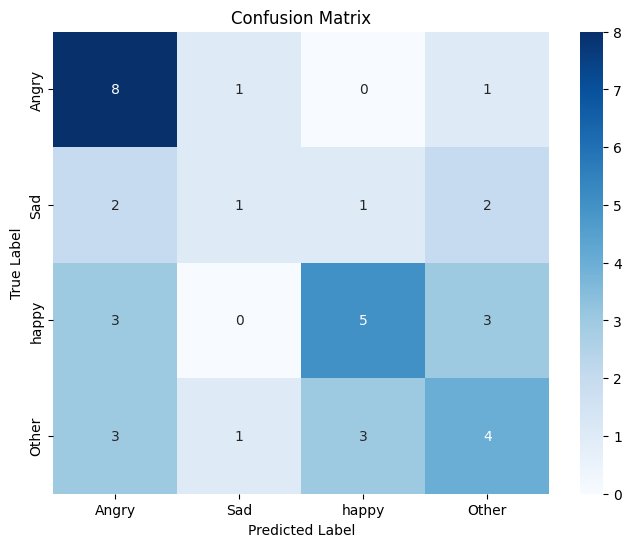

In [58]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
learning_rate = 1e-5
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        # Inception V3 returns two outputs during training
        outputs = model(inputs)
        main_output, aux_output = outputs.logits, outputs.aux_logits
        
        # Compute loss as a combination of main and auxiliary outputs
        loss = criterion(main_output, targets) + 0.4 * criterion(aux_output, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = main_output.max(1)  # Use main output for accuracy
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}", end="\r")

    train_accuracy = 100. * correct / total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Use only the main output during validation
            outputs = model(inputs)  # Returns only logits during eval mode
            loss = criterion(outputs, targets)
    
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

       

model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Use only the main output during testing
        outputs = model(inputs)  # Returns only logits during eval mode
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
# Calculate metrics
test_accuracy = 100. * correct / total
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print results
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix)
